# Create Centers

In [1]:
from matplotlib import pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import numpy as np
import glob
import random
from utils.encoding_utils import encode_coordinates,decode_coordinates

## Random centers above land

In [3]:


land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

def sample_random_spherical(n=1000):
    long = 360 * np.random.rand(n) - 180
    lat = np.arccos(1 - 2 * np.random.rand(n))*180/np.pi-90
    return np.array([lat,long]).T

In [26]:
land_sampled=[]
for c in sample_random_spherical(10000):
    if is_land(c[1],c[0]):
        land_sampled.append(c)
land_sampled = np.array(land_sampled)

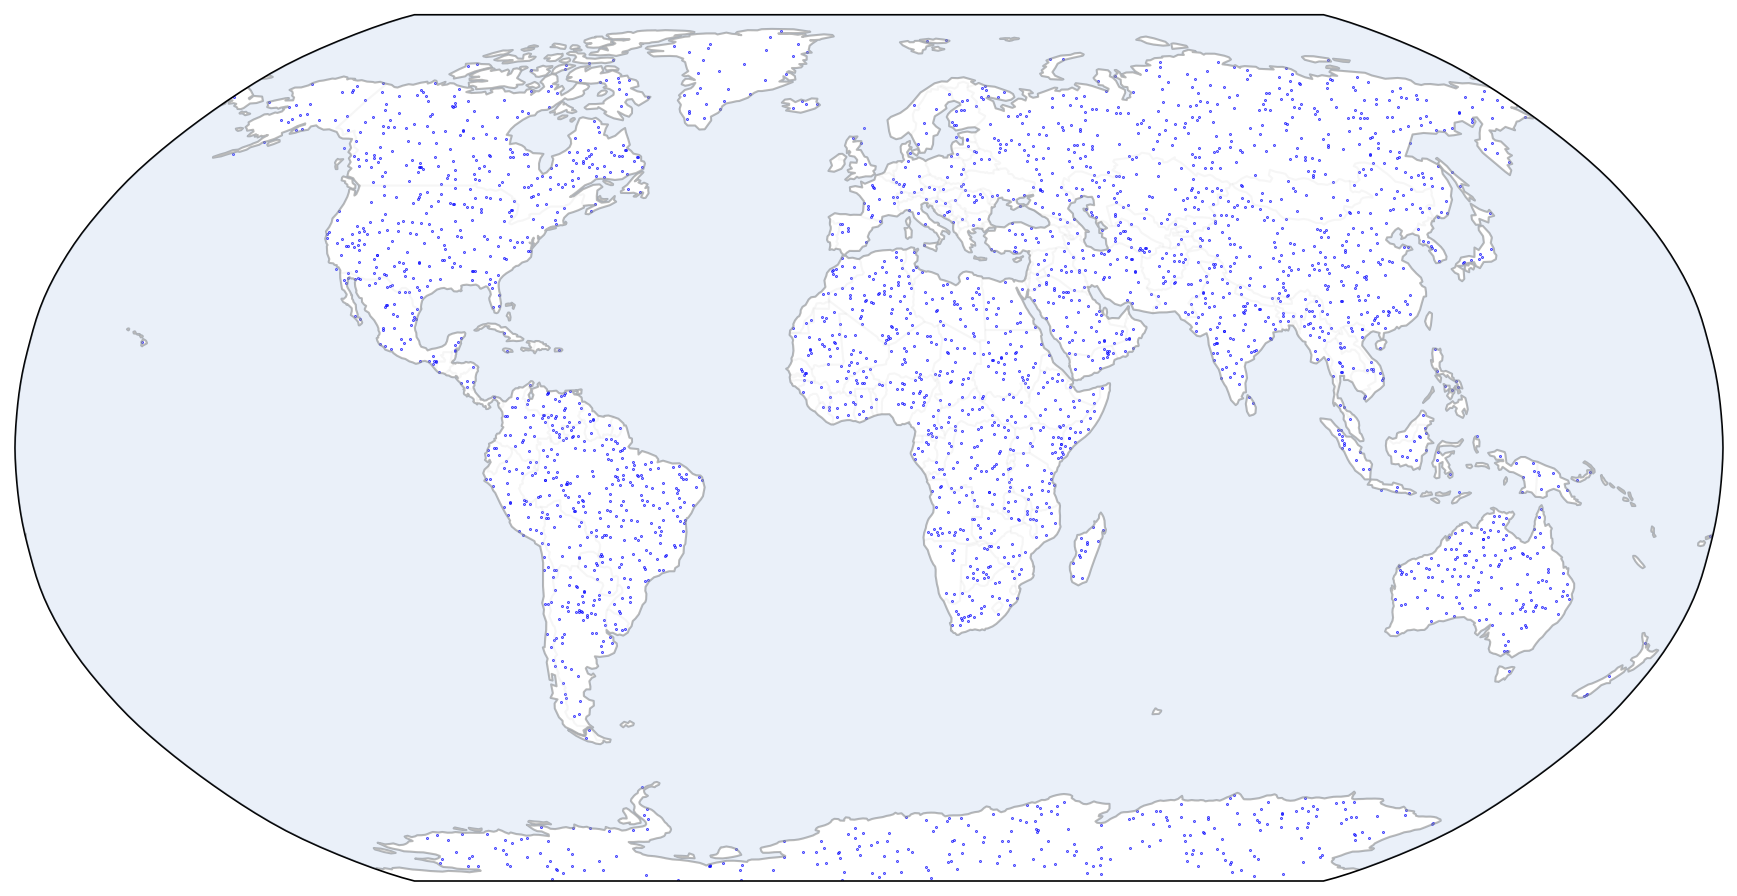

In [27]:
fig = plt.figure(figsize=(15,7.5), dpi= 150)
ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson())

ax.set_global()
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='lightgrey', alpha=0.5)
ax.add_feature(cfeature.BORDERS, zorder=2,edgecolor='lightgrey', alpha=0.2)
ax.add_feature(cfeature.OCEAN, zorder=3, alpha=0.2, edgecolor='black')

# ax.set_extent([20,35,50,67])
# ax.gridlines()
a = plt.scatter(x=land_sampled[:,1], y=land_sampled[:,0],  #x=long, y=lat
            color="blue",
            s=0.1,
            alpha=1,
            transform=crs.PlateCarree(),
            zorder=1
    )

In [32]:
# np.save('centers_ltlng_random_land', land_sampled)

## Close to training data locations

In [5]:
import config_geography
import tqdm
pos_feature_label = config_geography.feature_positions_label

In [6]:
x_train_files = glob.glob(f"/phileo_data/mini_foundation/mini_foundation_patches_np/patches_labeled/**/**train_label_geo.npy")
random.Random(12345).shuffle(x_train_files)

In [7]:
coords_t = []

for f in tqdm.tqdm(x_train_files):
    ar = np.load(f)

    coord= ar[:,pos_feature_label['coords']]
    coords_t.append(coord)

coords_t = np.vstack(coords_t)
coords_t = decode_coordinates(coords_t)



100%|██████████| 430/430 [00:19<00:00, 22.28it/s]


In [8]:
from math import radians, cos, sin, asin, sqrt

def haversine(c1, c2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lat1, lon1 = c1
    lat2, lon2 = c2 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [13]:
centers_at_trainlocs = []

for c in tqdm.tqdm(coords_t[np.random.randint(0,len(coords_t),900)]):
    found = False
    for cent in centers_at_trainlocs:
       if haversine(cent, c)<50:
        found =True
        continue
    
    if not found:
       centers_at_trainlocs.append(c)
centers_at_trainlocs = np.array(centers_at_trainlocs)


  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [00:00<00:00, 1623.62it/s]


In [34]:
# np.save('centers_ltlng_train_locations', centers_at_trainlocs)

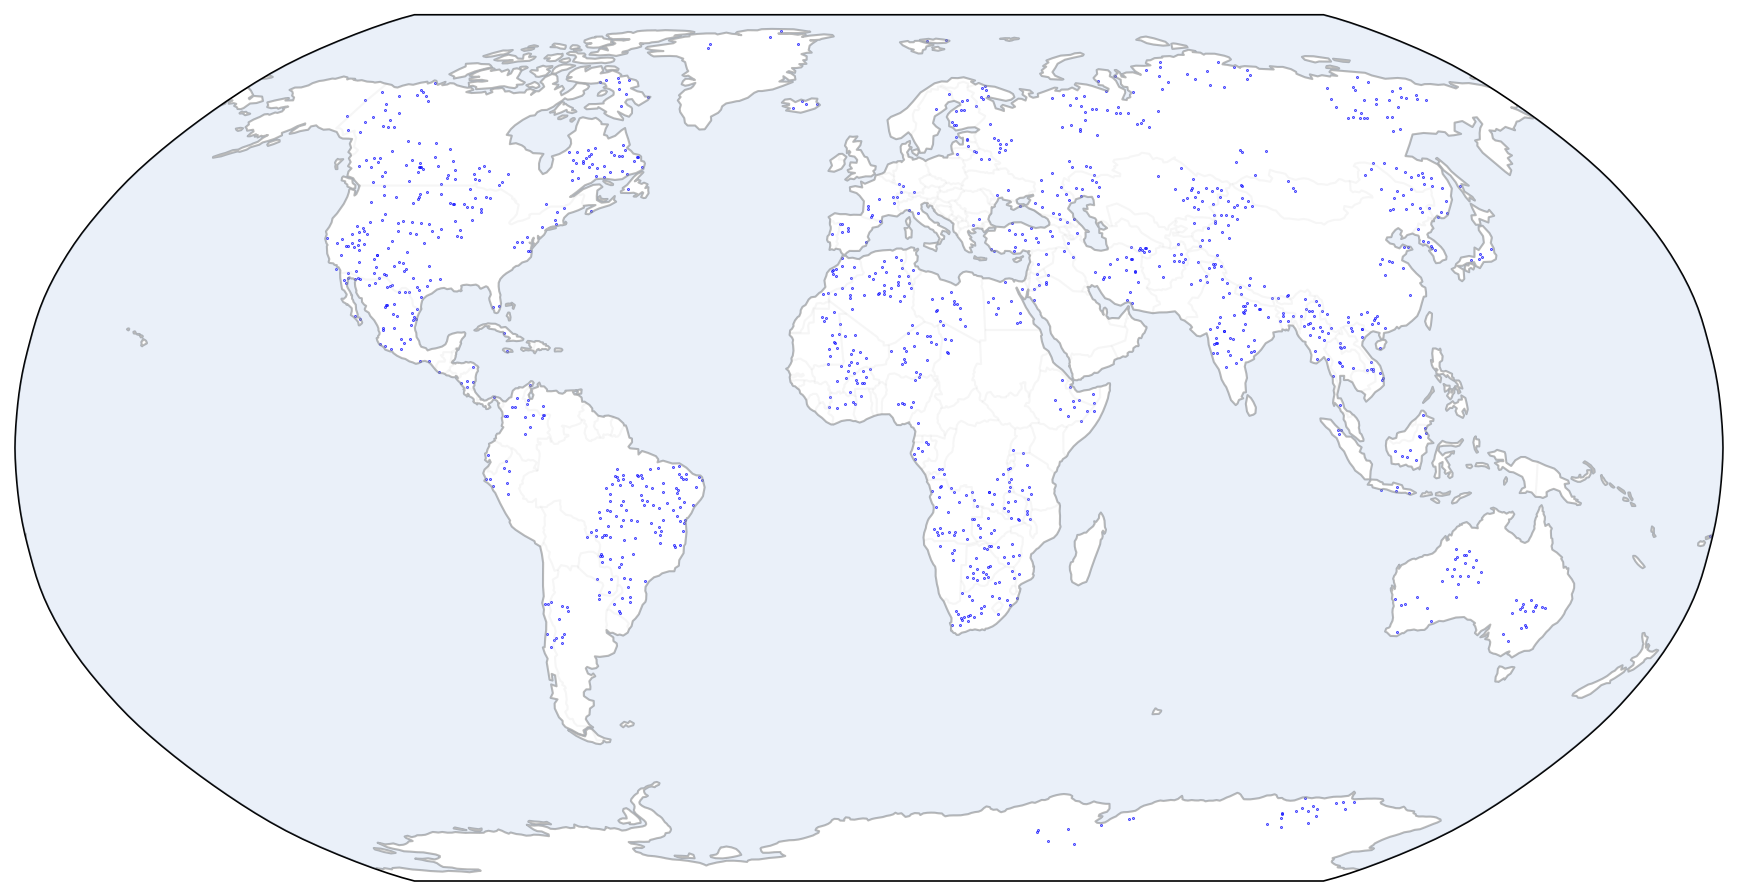

In [33]:
fig = plt.figure(figsize=(15,7.5), dpi= 150)
ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson())

ax.set_global()
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='lightgrey', alpha=0.5)
ax.add_feature(cfeature.BORDERS, zorder=2,edgecolor='lightgrey', alpha=0.2)
ax.add_feature(cfeature.OCEAN, zorder=3, alpha=0.2, edgecolor='black')

ax.set_extent([20,35,50,67])
ax.gridlines()
a = plt.scatter(x=centers_at_trainlocs[:,1], y=centers_at_trainlocs[:,0],  #x=long, y=lat
            color="blue",
            s=0.1,
            alpha=1,
            transform=crs.PlateCarree(),
            zorder=1
    )


# MvMF probability distribution

In [1]:
from utils.MvMF_utils import get_coordinate_array
from utils.encoding_utils import encode_coordinates, decode_coordinates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as crs
import cartopy.feature as cfeature

In [2]:


coords_global = get_coordinate_array([-89.9,89.9,-179.9,179.9], shape=(500,500)).reshape((2,-1))
coords_global_enc = np.array([encode_coordinates(coords_global[:,i]) for i in range(coords_global.shape[1])]).swapaxes(0,1).T

In [3]:
def dist_encoded(c1,ref):
    '''
    Calculates cosine of angle between points on the sphere (result between -1 and 1)
    coord_true: encoded coordinates
    centers: encoded coordinates of the centers defining the MvMF distrubution
    if coord_true.shape = (batch_size, 3) and centers.shape = (n_clusters,3) the output will have shape (batch_size, n_clusters)
    '''
    lat1_enc,long1_sin, long1_cos = c1[:,0], (2*c1[:,1]-1), (2*c1[:,2]-1)
    lat2_enc,long2_sin, long2_cos = ref[:,0],(2*ref[:,1]-1), (2*ref[:,2]-1)

    lat1_r = lat1_enc*np.pi
    lat2_r = lat2_enc*np.pi

    cos_dif = np.zeros((len(long2_cos),len(long1_cos)))
    cos_dif = np.outer(long2_cos,long1_cos) + np.outer(long2_sin,long1_sin)
    
    return np.outer(np.sin(lat2_r),np.sin(lat1_r))*cos_dif +np.outer(np.cos(lat2_r),np.cos(lat1_r))


def vMF_log(coordinate, density, center, clip=True):
    # log of vMF density 
    dist = dist_encoded(coordinate,center).T
    
    if clip: # due to luck some coordinates are very close to cluster centers leading to very high activation
        densest_centers_grid = np.sort(dist.max(axis=0)) 
        dist = np.clip(dist, -1, densest_centers_grid[0])

    return density + np.exp(density)*(dist-1)

In [4]:
center = np.array([[20,-100], [20,0], [20,60]])
center.shape

(3, 2)

In [4]:
density = [6,7,8,9,10,14]
center = [[20,-100], [20,0], [20,60],[20,100],[20,150],[20,170]]

density = np.array(density)
center = np.array(center)
center_encoded = encode_coordinates(center)
global_probability = vMF_log(coords_global_enc, density, center_encoded, clip=False )

#global_probability = np.sum(global_probability, axis=-1)
global_probability = np.exp(global_probability)
global_probability = np.sum(global_probability, axis=-1)


/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


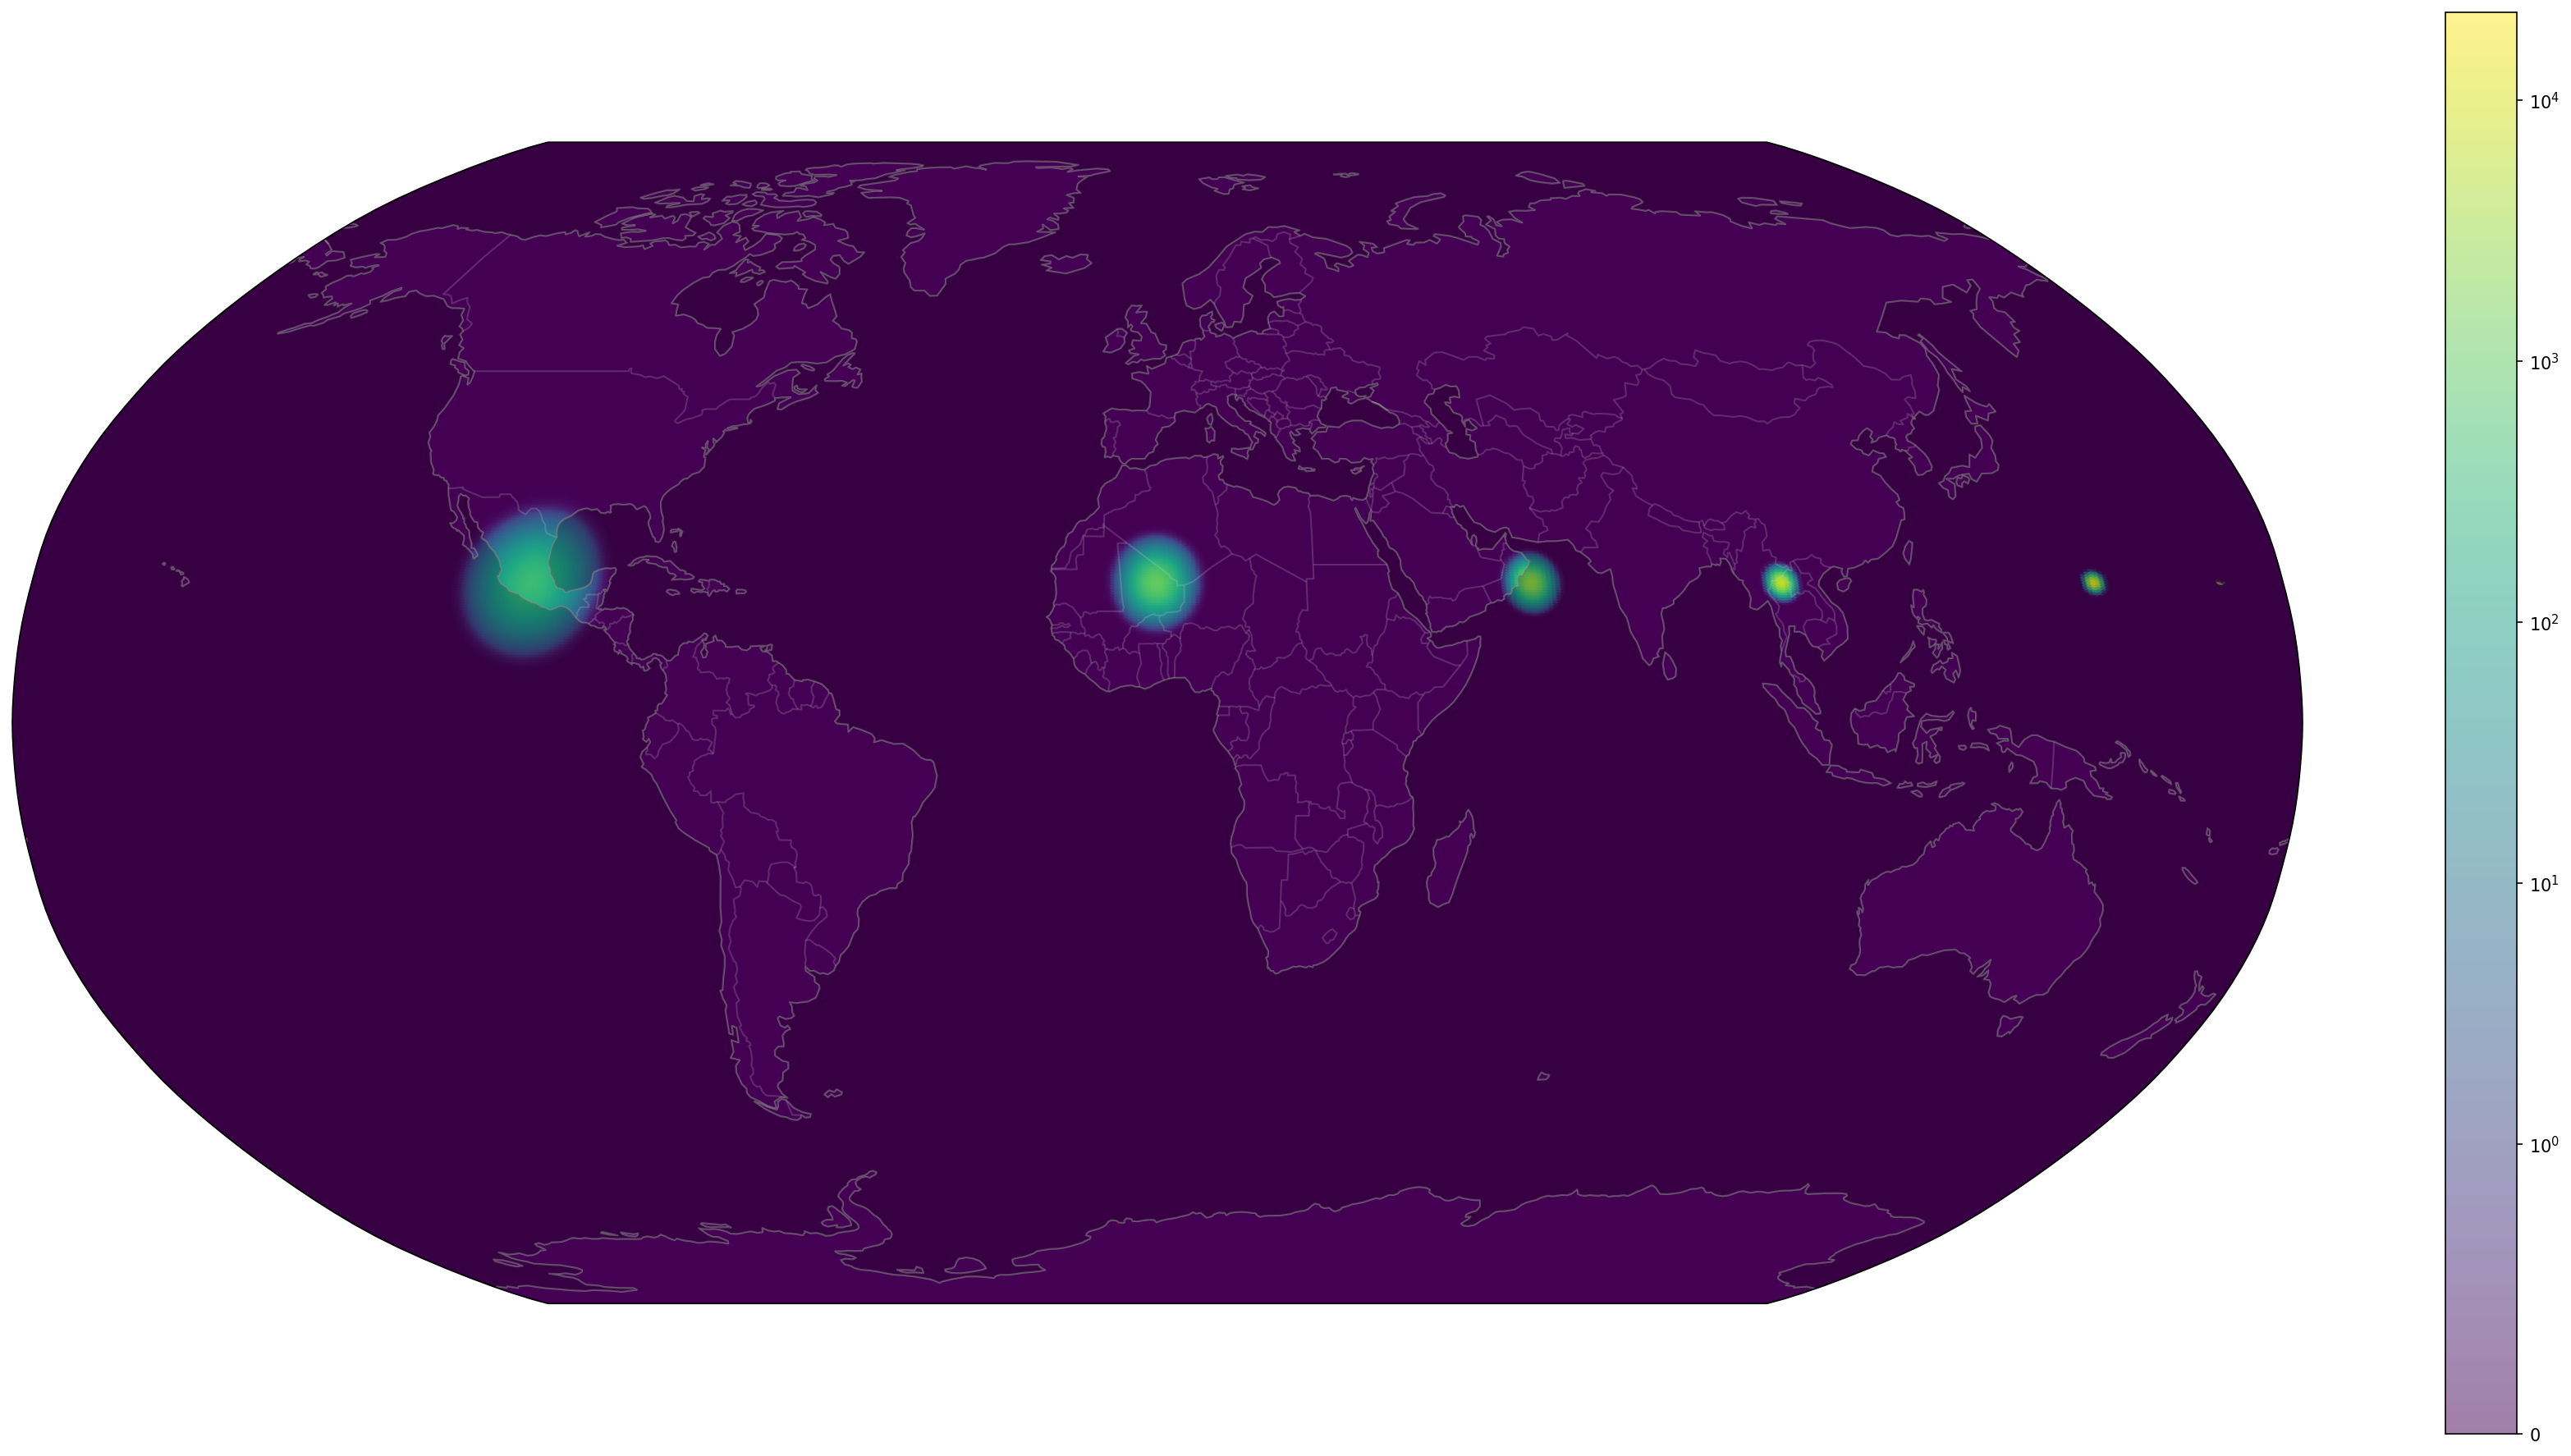

In [8]:
fig = plt.figure(figsize=(30,15), dpi= 150)
ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson())
#ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
ax.set_global()
ax.add_feature(cfeature.COASTLINE, zorder=2, color='lightgrey', alpha=0.5)
ax.add_feature(cfeature.BORDERS, zorder=2,color='lightgrey', alpha=0.2)
ax.add_feature(cfeature.OCEAN, zorder=3, alpha=0.2, color='black')

# ax.set_extent([20,35,50,67])
# ax.gridlines()
a = plt.scatter(x=coords_global[1,:], y=coords_global[0,:],  #x=long, y=lat
            #color="dodgerblue",
            c= global_probability,
            # cmap='hot',
            alpha=0.5,
            transform=crs.PlateCarree(),
            norm=matplotlib.colors.SymLogNorm(linthresh=1, vmin=1e-20) ## Important

    )
plt.colorbar()

# MvMF loss

In [1]:
from utils.MvMF_utils import MvMFLoss
import numpy as np
import torch

In [2]:
centers = np.load('centers_ltlng_random_land.npy')
densities = np.array([5 + 2*np.random.rand() for i in range(len(centers))])

In [3]:
centers.shape

(2861, 2)

In [47]:
loss = MvMFLoss(center_inits = centers, density_inits=densities, centers_learnable=True, density_learnable=True, softmax_input=True, device='cpu')

In [48]:
bs=1

# output of model will be vector of  size (batch_size, len(centers)
model_output = np.ones((bs,len(centers)))

# # artificially activate some centers. If softmax_input=True, these values can be raw logits and don't need to sum to 1
model_output = model_output*np.random.rand(bs,len(centers))

# true coordinate (labels) should be encoded
true_coordinate = np.array([[20,-100] for i in range(bs)])
true_coordinate_encoded = encode_coordinates(true_coordinate)

# put on torch
true_coordinate_encoded = torch.tensor(true_coordinate_encoded)
model_output = torch.tensor(model_output)


In [49]:
loss(model_output, true_coordinate_encoded)

tensor(-0.5751, dtype=torch.float64, grad_fn=<MeanBackward0>)

# Create location heatmaps

In [50]:
from utils.MvMF_utils import MvMF_visuals
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

# initilise with encoded centers and densities from trained model
centers = np.load('centers_random_land.npy') # in lat-long
densities = np.array([5 + 2*np.random.rand() for i in range(len(centers))])

vis = MvMF_visuals(centers=centers, densities=densities, encode_centers=True)


In [51]:
# initialised with coordinate raster spanning the entire globe 
vis.coords_global.shape

(360000, 2)

In [52]:
cluster_probabilities = vMF_log(vis.coords_global_enc, vis.densities, vis.centers)

In [53]:
# for every point on the global map, we have for each center it's activation
cluster_probabilities.shape

(360000, 2890)

In [54]:
model_output = np.zeros((1,len(centers)))# the weights for every cluster

# let's say the 5th and 500th cluster got high activation from the model
model_output[:,[5,500]]=100

# and let's say cluster 500 was actually the closes
coord_true = centers[500]

In [55]:
exp_weights = np.exp(model_output)
soft_maxed = exp_weights/np.sum(exp_weights, axis=-1, keepdims=True)

# in case weights is a vector of size (n_patches, n_centers) take average over all weights
soft_maxed = np.mean(soft_maxed, axis=0)


In [56]:
heatmap = np.matmul(np.exp(cluster_probabilities), soft_maxed.T)

In [57]:
# or everything at once, with the possibility for computational speed to only take best 50 cluster into account
heatmap = vis.get_heatmap(coordinate=vis.coords_global_enc, density=vis.densities, centers=vis.centers, weights=model_output, max_clusters=50)

(50, 3)


/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/andreas/miniconda3/envs/rs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


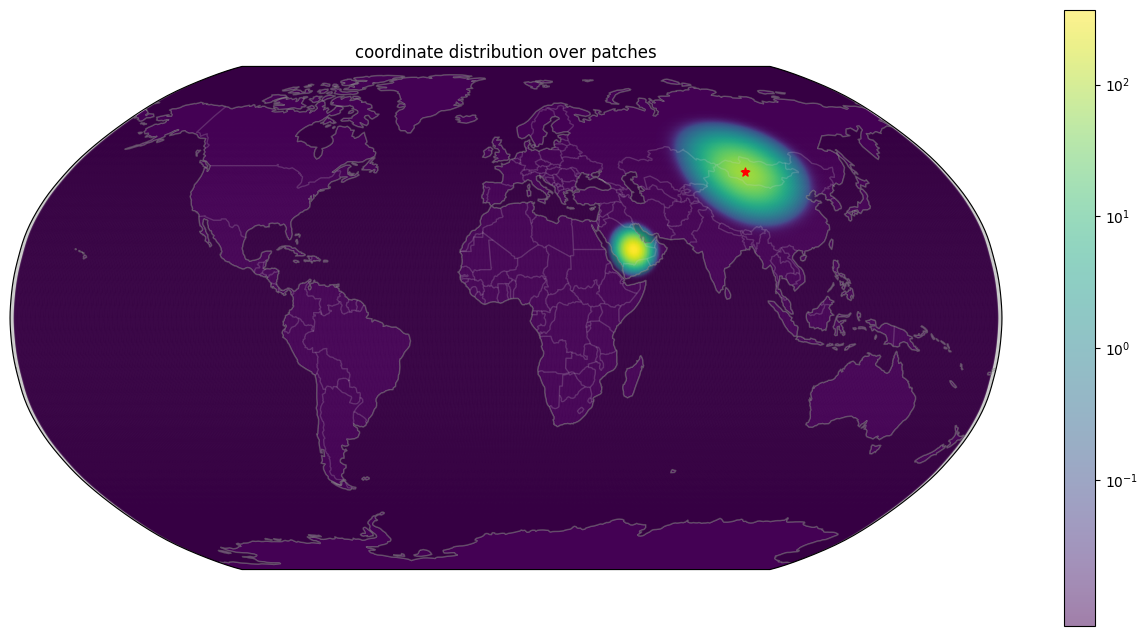

In [58]:
fig = plt.figure(figsize=(16 , 8 ))
ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson())

vis.plot_globe_dist(ax,heatmap,coord_true=coord_true)